MINC 2500 Tutorial : take a pre-trained network and fine-tune it on new classification task

THALES DMS France, 2019, Atelier ALLOHA du 15/01/2019

Import lib

In [1]:
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, Model
from keras.layers import Activation, Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Input
from keras import applications
from keras.applications.vgg16 import preprocess_input
from keras import backend as K
from keras import optimizers
from keras.datasets import mnist
from keras.utils import to_categorical
import matplotlib.pyplot as plt
import numpy as np

/home/user/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


Database

In [2]:
train_data_dir = '/home/user/privatedata/MINC2500/minc-2500/train'
validation_data_dir = '/home/user/privatedata/MINC2500/minc-2500/test'
# 1001 training samples for each of the 23 classes
nb_train_samples = 1001*23
# 1499 validation samples for each of the 23 classes
nb_validation_samples = 1499*23

Images dimensions

In [3]:
img_width, img_height = 150, 150
if K.image_data_format() == 'channels_first':
    input_shape = (3, img_width, img_height)
else:
    input_shape = (img_width, img_height, 3)

Training parameters

In [4]:
epochs = 20
batch_size = 16
top_model_weights_path = 'bottleneck_fc_model.h5'

Load VGG16 without fully-connected layers

In [5]:
input_tensor = Input(shape=input_shape)
base_model = applications.VGG16(weights='imagenet', include_top=False, input_tensor=input_tensor)
print('VGG16 Model loaded.')

VGG16 Model loaded.


Add a dense neural network on top

In [6]:
top_model = Sequential()
top_model.add(Flatten(input_shape=base_model.output_shape[1:]))
top_model.add(Dense(256, activation='relu'))
top_model.add(Dropout(0.5))
top_model.add(Dense(23, activation='softmax'))
# It is recommended to start with a fully-trained classifier, including the top classifier,
# in order to successfully do fine-tuning
top_model.load_weights(top_model_weights_path)

model = Model(inputs=base_model.input, outputs=top_model(base_model.output))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0         
__________

Set the first 15 layers (up to the last conv block) to non-trainable (weights will not be updated)

In [7]:
for layer in model.layers[:15]:
    layer.trainable = False

Compile the model with a SGD/momentum optimizer and a very slow learning rate.

In [8]:
model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.SGD(lr=1e-6, momentum=0.75),
              metrics=['accuracy'])

Data

In [9]:
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=10,
    zoom_range=0.2,
    horizontal_flip=True)

test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical')

validation_generator = test_datagen.flow_from_directory(
    validation_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical')

Found 23023 images belonging to 23 classes.
Found 34477 images belonging to 23 classes.


Fine-tune the model

In [10]:
history = model.fit_generator(
    train_generator,
    steps_per_epoch=nb_train_samples//batch_size,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=nb_validation_samples//batch_size)


Epoch 1/20
1438/1438 [==============================] - 454s 316ms/step - loss: 6.2130 - acc: 0.5935 - val_loss: 5.4540 - val_acc: 0.6447
Epoch 2/20
1438/1438 [==============================] - 453s 315ms/step - loss: 5.9959 - acc: 0.6074 - val_loss: 5.3895 - val_acc: 0.6479
Epoch 3/20
1438/1438 [==============================] - 450s 313ms/step - loss: 5.9201 - acc: 0.6111 - val_loss: 5.3366 - val_acc: 0.6506
Epoch 4/20
1438/1438 [==============================] - 450s 313ms/step - loss: 5.8633 - acc: 0.6154 - val_loss: 5.3189 - val_acc: 0.6525
Epoch 5/20
1438/1438 [==============================] - 450s 313ms/step - loss: 5.6678 - acc: 0.6274 - val_loss: 5.2915 - val_acc: 0.6541
Epoch 6/20
1438/1438 [==============================] - 450s 313ms/step - loss: 5.6587 - acc: 0.6268 - val_loss: 5.2280 - val_acc: 0.6590
Epoch 7/20
1438/1438 [==============================] - 450s 313ms/step - loss: 5.5602 - acc: 0.6331 - val_loss: 5.2012 - val_acc: 0.6597
Epoch 8/20
1438/1438 [============

Plot

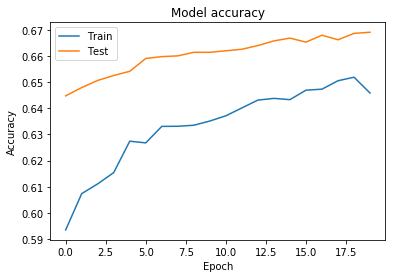

In [11]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

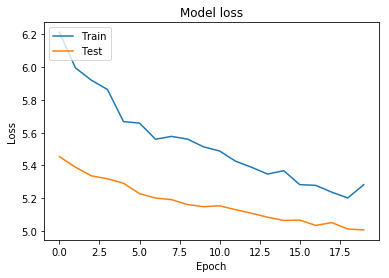

In [12]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()